# Title HERE
---
* TEMP
* TEMP

# Notebook Setup
  * Import modules
  * Import data
  * Proprocessing

## Script Inputs

In [1]:
verbose = False

pH = 0

bias_range = [-3, 3]

## Import Modules

In [2]:
%%capture
import os
import sys

# #############################################################################
sys.path.insert(0,
    os.path.join(
        os.environ["PROJ_irox"],
        "workflow"))
from an_data_processing import load_df
# from an_data_processing import oxy_ref, hyd_ref

# # #############################################################################
import pickle
import pandas as pd

# # #############################################################################
from misc_modules.pandas_methods import drop_columns
from surface_energy.surface_energy import SurfaceEnergy

In [3]:
from proj_data_irox import irox_surface_e_color_map

import plotly.graph_objects as go

from plotting.my_plotly import my_plotly_plot

from plotly.subplots import make_subplots
import plotly.graph_objects as go

from layout__v0 import layout

In [4]:
from proj_data_irox import bulk_e_per_atom_dict

## Read data

In [5]:
dataframe_dir = os.path.join(
    os.environ["PROJ_DATA"],
    "04_IrOx_surfaces_OER/190321_new_job_df")

df_pourbaix, df_ads, df_surf = load_df(
    from_file=True,
    root_dir=dataframe_dir,
    data_dir=dataframe_dir,
    file_name="df_master.pickle",
    process_df=True)
df_m = df_surf


# Filter the jobs that were unsuccessful
df_m = df_m[[not i for i in pd.isna(df_m["elec_energy"].tolist())]]
df_m = df_m[df_m["job_type"] == "surface_coverage_energy"]


cols_to_keep = [
    'facet',
    'job_type',
    'layers',
    'surface_type',
    'elec_energy',
    'atoms_object',
    'bulk_system',
    'coverage_type',
    ]

df_m = drop_columns(df=df_m, columns=cols_to_keep, keep_or_drop="keep")

Attempting to load df from pickle


## Read bulk data

In [6]:
bulk_data_path = os.path.join(
    os.environ["PROJ_irox"],
    "workflow/an_bulk_systems",
    "bulk_systems.pickle")
with open(bulk_data_path, "rb") as fle:
    bulk_data = pickle.load(fle)

# Read Adsorbate and Gas Reference Data

In [7]:
# surf_spec_corr_dict = {"*OH": 0.2945, "*O": 0.044, "*OOH": 0.3765}

import pickle
path_i = os.path.join(
    os.environ["PROJ_irox"],
    "workflow/energy_treatment_deriv/out_data",
    "data.pickle")
with open(path_i, "rb") as fle:
    data = pickle.load(fle)


surf_spec_corr_dict = {
    "*OH": data["D_phi_oh_ads"],
    "*O": data["D_phi_o_ads"],
    "*OOH": data["D_phi_ooh_ads"],
    }

hyd_ref = data["E_H_ref"]
oxy_ref = data["E_O_ref"]

## Instantiate SurfaceEnergy objects

In [8]:
%%capture

def method(row_i):
    """
    """
    print(row_i["bulk_system"] + "_" + row_i["facet"] + "_" + row_i["coverage_type"])

    bulk_e_per_atom = bulk_e_per_atom_dict[row_i["bulk_system"]]

    SE = SurfaceEnergy(
        atoms=row_i["atoms_object"][-1],
        bulk_atoms=bulk_data[row_i["bulk_system"]],
        bulk_electronic_energy_per_atom=bulk_e_per_atom,
        H_ref_electronic_energy=hyd_ref,
        O_ref_electronic_energy=oxy_ref,
        special_surface_species_corrections=surf_spec_corr_dict,
        verbose=verbose,
        )

    print("index: ", row_i.name)
    print("")

    return(SE)

df_m["SurfaceEnergy"] = df_m.apply(
    method,
    axis=1,
    )

In [9]:
row_i = df_m.iloc[0]


SE_i = row_i["SurfaceEnergy"]

norm_type = "area"  # 'area', 'surface_atom'
# #############################################################################

surf_e_left = SE_i.calc_surface_energy(bias_range[0], pH, norm_type="area")
surf_e_right = SE_i.calc_surface_energy(bias_range[1], pH, norm_type="area")


In [10]:
# TEMP

# import numpy as np
# bias_list = np.arange(bias_range[0], bias_range[1], 0.1)

# surf_e_list = []
# for bias_i in bias_list:
#     surf_e_i = SE_i.calc_surface_energy(bias_i, pH, norm_type="area")
#     surf_e_list.append(surf_e_i)

In [11]:
def method(row_i):
    """
    """
    SE_i = row_i["SurfaceEnergy"]

    norm_type = "area"  # 'area', 'surface_atom'

    # #############################################################################
    # #############################################################################
    import numpy as np
    bias_list = np.arange(bias_range[0], bias_range[1], 0.1)

    surf_e_list = []
    for bias_i in bias_list:
        surf_e_i = SE_i.calc_surface_energy(bias_i, pH, norm_type="area")
        surf_e_list.append(surf_e_i)
    # #############################################################################
    # #############################################################################

    surf_e_left = SE_i.calc_surface_energy(bias_range[0], pH, norm_type="area")
    surf_e_right = SE_i.calc_surface_energy(bias_range[1], pH, norm_type="area")


    color_i = irox_surface_e_color_map.get(
        row_i["bulk_system"] + "_" + row_i["coverage_type"]
        )
    name_i = row_i["coverage_type"] + " " + row_i["facet"] 

    trace_i = go.Scatter(
        x=bias_list,
        y=surf_e_list,
#         x=bias_range,
#         y=[surf_e_left, surf_e_right],

#         mode='markers+lines',
        mode='lines',
        name=name_i,
        hoverinfo="name",
        marker=dict(
            symbol="square",
            size=10,
            color=color_i,
            line=dict(
                width=1,
                color='rgb(0, 0, 0)',
                ),
            ),
        )
    return(trace_i)


df_m["plotly_trace"] = df_m.apply(
    method,
    axis=1,
    )

In [12]:
def make_surf_e_pourb_plot(
    df_m=None,
    num_cols=2,
    layout=None,
    ):
    """
    """
    num_plots = len(df_m["bulk_system"].unique())

    fig = make_subplots(
        rows=int(num_plots / num_cols),
        cols=num_cols,
        shared_xaxes=True,
        vertical_spacing=0.05,
        x_title="TEMP TEMP TEMP",
        )

    grouped = df_m.groupby(["bulk_system"])

    row_cnt = 1
    col_cnt = 1
    for i_cnt, (name, group) in enumerate(grouped):

        trace_1_23 = go.Scatter(
            x=2 * [1.23],
            y=[-5, 5],
            mode='lines',
            name="1.23",
            line=dict(
                color="black",
                width=1,
                dash="dot",
                ))

        fig.add_trace(trace_1_23, row=row_cnt, col=col_cnt)

        for j_cnt, row_j in group.iterrows():
            fig.add_trace(
                row_j["plotly_trace"],
                row=row_cnt,
                col=col_cnt,
                )

        # Advance row and column index
        col_cnt += 1
        if col_cnt > num_cols:
            col_cnt = 1
            row_cnt += 1


    tmp = fig.update_layout(layout)

    return(fig)

In [13]:
fig = make_surf_e_pourb_plot(df_m=df_m, num_cols=2, layout=layout)

In [14]:
from IPython.display import Image

Writing pdf with ORCA
Creating png image file | s89adsrfg0jasd56


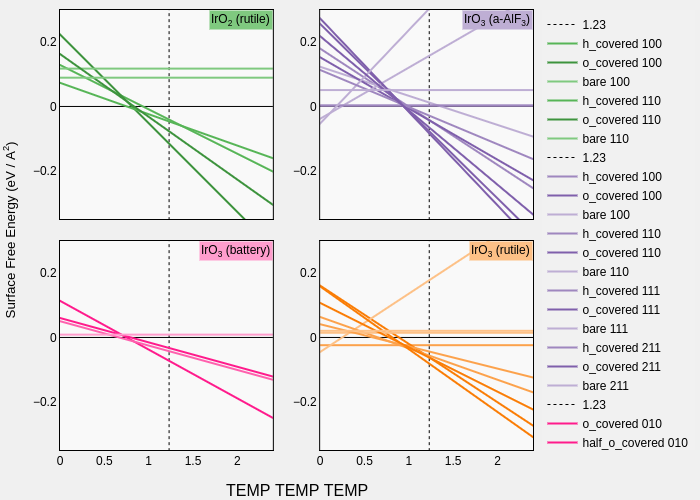

In [15]:
plot_name_i = "surf_e_pourbaix_irox__large"
fig = my_plotly_plot(
    figure=fig,
    layout=None,
    layout_override=None,
    plot_name=plot_name_i,
    save_dir=None,
    data=None,
    upload_plot=False,
    write_pdf_svg=True,
    )

# fig.show()

Image("out_plot/" + plot_name_i + ".png")

In [16]:
%%capture

fig = make_surf_e_pourb_plot(df_m=df_m, num_cols=1, layout=layout)

fig.layout.update(dict(
    showlegend=False,
    width=8.0 * 37.795275591,
    height=15.0 * 37.795275591,
    ))

Writing pdf with ORCA
Creating png image file | s89adsrfg0jasd56


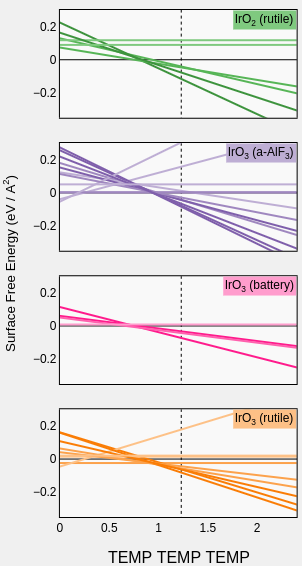

In [17]:
plot_name_i = "surf_e_pourbaix_irox__regular"
fig = my_plotly_plot(
    figure=fig,
    layout=None,
    layout_override=None,
    plot_name=plot_name_i,
    save_dir=None,
    data=None,
    upload_plot=False,
    write_pdf_svg=True,
    )

# fig.show()

Image("out_plot/" + plot_name_i + ".png")

# Standard Surface Energy Bar Chart

Writing pdf with ORCA
Creating png image file | s89adsrfg0jasd56


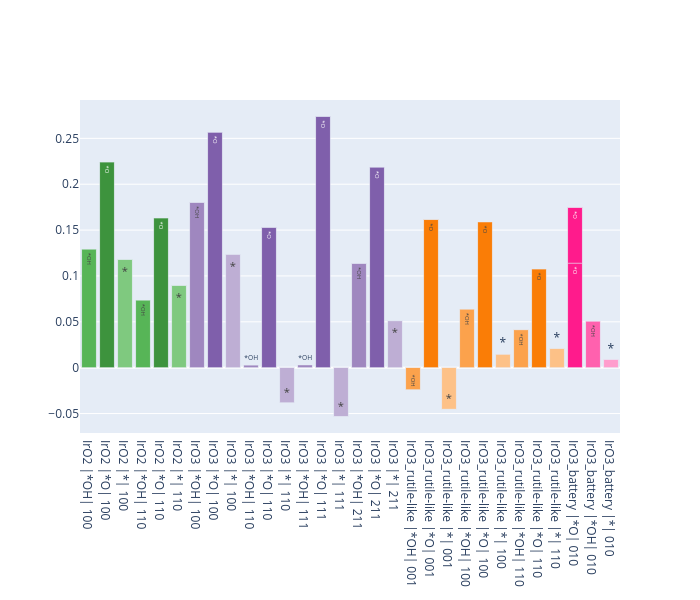

In [18]:
name_list = []
surf_e_list = []
color_list = []
label_list = []
for i_cnt, row_i in df_m.iterrows():
    
    # #########################################################################
    if row_i["coverage_type"] == "h_covered":
        label_i = "*OH"
    elif row_i["coverage_type"] == "o_covered":
        label_i = "*O"
    elif row_i["coverage_type"] == "bare":
        label_i = "*"
    elif row_i["coverage_type"] == "half_o_covered":
        label_i = "*O"
    else:
        print(row_i["coverage_type"])
        label_i = "TEMP"

    label_list.append(label_i)

    # #########################################################################
    surf_e_i = row_i["SurfaceEnergy"].std_surface_e_per_area
    surf_e_list.append(surf_e_i)

    # #########################################################################
#     name_i = row_i["bulk_system"] + " " + row_i["coverage_type"] + " " + row_i["facet"]
    name_i = row_i["bulk_system"] + " |" + label_i + "| " + row_i["facet"]

    name_list.append(name_i)

    # #########################################################################
    color_i = irox_surface_e_color_map.get(
        row_i["bulk_system"] + "_" + row_i["coverage_type"])
    color_list.append(color_i)


fig = go.Figure(
    data=[
        go.Bar(
            name='SF Zoo',
            x=name_list,
            y=surf_e_list,
            marker_color=color_list,
            text=label_list,
            textposition='auto',
            ),
        ],
    layout=go.Layout(
        height=600,
#         width=,
        )
    )

# Change the bar mode
fig.update_layout(barmode='group')

plot_name_i = "std_surf_e_bar_plot"
fig = my_plotly_plot(
    figure=fig,
    plot_name=plot_name_i,
    save_dir=None,
    upload_plot=False,
    )


# fig.show()

Image("out_plot/" + plot_name_i + ".png")